#Q3 part a

## Q_Learning

###1. INSTALL AND IMPORT REQUIRED PACKAGES

In [ ]:
# Import all necessary libraries
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for Colab
%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(84)
random.seed(84)

### 2. ENVIRONMENT CLASS

In [ ]:
class GridEnvironment:
    """
    Wumpus World Environment for Q-Learning

    🎯 Goal: Navigate a 4x4 grid to find gold while avoiding dangers
    🏆 Rewards: +100 (gold), +50 (kill wumpus), -1000 (death), -1 (move)
    """

    def __init__(self):
        # Grid setup
        self.grid_size = 4
        self.agent_position = [0, 0]  # Start at top-left
        self.gold_position = [3, 3]   # Goal at bottom-right
        self.pits = [[1, 1], [2, 2]]  # Dangerous pits
        self.wumpus_position = [1, 3] # Monster location
        self.wumpus_alive = True
        self.arrow_available = True

        # Action names for display
        self.action_names = ['up', 'down', 'left', 'right',
                           'shoot_up', 'shoot_down', 'shoot_left', 'shoot_right']

        print("🌍 Wumpus World Environment Created!")
        print(f"📍 Agent starts at: {self.agent_position}")
        print(f"🏆 Gold location: {self.gold_position}")
        print(f"👹 Wumpus location: {self.wumpus_position}")
        print(f"🕳️ Pit locations: {self.pits}")

    def reset(self):
        """Reset environment to initial state"""
        self.agent_position = [0, 0]
        self.wumpus_position = [1, 3]
        self.wumpus_alive = True
        self.arrow_available = True
        return self.get_state()

    def step(self, action):
        """Execute action and return (next_state, reward, done)"""
        reward = -1  # Movement penalty
        done = False
        x, y = self.agent_position

        # Movement actions (0-3)
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.grid_size - 1, y + 1)

        # Shooting actions (4-7)
        elif action == 4 and self.arrow_available:  # Shoot up
            self.arrow_available = False
            if (self.wumpus_position[1] == y and
                self.wumpus_position[0] < x and self.wumpus_alive):
                reward = 50
                self.wumpus_alive = False

        elif action == 5 and self.arrow_available:  # Shoot down
            self.arrow_available = False
            if (self.wumpus_position[1] == y and
                self.wumpus_position[0] > x and self.wumpus_alive):
                reward = 50
                self.wumpus_alive = False

        elif action == 6 and self.arrow_available:  # Shoot left
            self.arrow_available = False
            if (self.wumpus_position[0] == x and
                self.wumpus_position[1] < y and self.wumpus_alive):
                reward = 50
                self.wumpus_alive = False

        elif action == 7 and self.arrow_available:  # Shoot right
            self.arrow_available = False
            if (self.wumpus_position[0] == x and
                self.wumpus_position[1] > y and self.wumpus_alive):
                reward = 50
                self.wumpus_alive = False

        # Update position (only for movement)
        if action <= 3:
            self.agent_position = [x, y]

        # Check terminal conditions
        if self.agent_position == self.gold_position:
            reward = 100  # Found gold!
            done = True
        elif self.agent_position in self.pits:
            reward = -1000  # Fell in pit
            done = True
        elif (self.agent_position == self.wumpus_position and self.wumpus_alive):
            reward = -1000  # Eaten by Wumpus
            done = True

        return self.get_state(), reward, done

    def get_state(self):
        """Return state as tuple for Q-learning"""
        return (self.agent_position[0], self.agent_position[1],
                self.wumpus_position[0], self.wumpus_position[1],
                self.wumpus_alive, self.arrow_available)

    def get_possible_actions(self):
        """Return all possible actions"""
        return list(range(8))

    def visualize(self):
        """Create a nice visualization of the current state"""
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

        # Create grid
        grid = np.zeros((4, 4))

        # Color coding
        colors = ['white', 'gold', 'red', 'brown', 'blue', 'green']

        # Create display grid
        display_grid = np.ones((4, 4)) * 0  # Start with white

        # Add elements
        display_grid[self.gold_position[0], self.gold_position[1]] = 1  # Gold
        for pit in self.pits:
            display_grid[pit[0], pit[1]] = 2  # Pits in red
        if self.wumpus_alive:
            display_grid[self.wumpus_position[0], self.wumpus_position[1]] = 3  # Wumpus in brown
        display_grid[self.agent_position[0], self.agent_position[1]] = 4  # Agent in blue

        # Create custom colormap
        from matplotlib.colors import ListedColormap
        cmap = ListedColormap(['white', 'gold', 'red', 'brown', 'blue'])

        im = ax.imshow(display_grid, cmap=cmap, vmin=0, vmax=4)

        # Add grid lines
        ax.set_xticks(np.arange(-0.5, 4, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 4, 1), minor=True)
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

        # Add labels
        for i in range(4):
            for j in range(4):
                if [i, j] == self.agent_position:
                    ax.text(j, i, 'A', ha='center', va='center', fontsize=20, fontweight='bold')
                elif [i, j] == self.gold_position:
                    ax.text(j, i, 'G', ha='center', va='center', fontsize=20, fontweight='bold')
                elif [i, j] in self.pits:
                    ax.text(j, i, 'P', ha='center', va='center', fontsize=20, fontweight='bold', color='white')
                elif [i, j] == self.wumpus_position and self.wumpus_alive:
                    ax.text(j, i, 'W', ha='center', va='center', fontsize=20, fontweight='bold', color='white')

        ax.set_title('Wumpus World State\nA=Agent, G=Gold, W=Wumpus, P=Pit', fontsize=14, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])

        # Add status
        status = f"Arrow: {'Available' if self.arrow_available else 'Used'}\n"
        status += f"Wumpus: {'Alive' if self.wumpus_alive else 'Dead'}"
        plt.figtext(0.02, 0.02, status, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

        plt.tight_layout()
        plt.show()

print("✅ Environment class created!")

✅ Environment class created!


### 3. Q-LEARNING AGENT CLASS

In [ ]:
class QLearningAgent:
    """
    Q-Learning Agent for Wumpus World

    🧠 Uses tabular Q-learning with epsilon-greedy exploration
    📊 Q-values stored in nested dictionary structure
    """

    def __init__(self, env, learning_rate=0.1, discount_factor=0.9,
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration=0.01):
        """Initialize Q-Learning Agent"""
        self.env = env
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration

        print("🤖 Q-Learning Agent Created!")
        print(f"📚 Learning Rate: {learning_rate}")
        print(f"🔮 Discount Factor: {discount_factor}")
        print(f"🎲 Initial Exploration: {exploration_rate}")

    def get_q_value(self, state, action):
        """Get Q-value for state-action pair"""
        return self.q_table[state][action]

    def update_q_value(self, state, action, reward, next_state):
        """Update Q-value using Q-learning formula"""
        # Find best next action
        next_actions = self.env.get_possible_actions()
        best_next_q = max([self.get_q_value(next_state, a) for a in next_actions])

        # Q-learning update
        current_q = self.get_q_value(state, action)
        td_target = reward + self.discount_factor * best_next_q
        td_error = td_target - current_q
        new_q = current_q + self.learning_rate * td_error

        self.q_table[state][action] = new_q

    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(self.env.get_possible_actions())
        else:
            actions = self.env.get_possible_actions()
            q_values = [self.get_q_value(state, a) for a in actions]
            best_actions = [a for a, q in zip(actions, q_values) if q == max(q_values)]
            return random.choice(best_actions)

    def train(self, episodes, verbose=True):
        """Train the Q-learning agent"""
        total_rewards = []
        success_count = 0

        print(f"🏋️ Starting training for {episodes} episodes...")
        print("=" * 60)

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            done = False
            steps = 0
            max_steps = 200

            while not done and steps < max_steps:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, reward, next_state)

                state = next_state
                total_reward += reward
                steps += 1

            total_rewards.append(total_reward)
            if total_reward > 0:
                success_count += 1

            # Decay exploration
            self.exploration_rate = max(self.min_exploration,
                                      self.exploration_rate * self.exploration_decay)

            # Print progress
            if verbose and (episode + 1) % 100 == 0:
                avg_reward = np.mean(total_rewards[-100:])
                success_rate = success_count / (episode + 1) * 100
                print(f'Episode {episode+1:4d} | '
                      f'Avg Reward: {avg_reward:6.2f} | '
                      f'Success Rate: {success_rate:5.1f}% | '
                      f'ε: {self.exploration_rate:.3f} | '
                      f'Q-states: {len(self.q_table)}')

        print("=" * 60)
        print("🎉 Training completed!")
        return total_rewards

print("✅ Q-Learning Agent class created!")

✅ Q-Learning Agent class created!


### 4. VISUALIZATION FUNCTIONS

In [ ]:
def plot_training_results(total_rewards, title="Q-Learning Training Results"):
    """Create comprehensive training plots"""
    # Calculate statistics
    cumulative_rewards = np.cumsum(total_rewards)
    mean_rewards = cumulative_rewards / (np.arange(len(total_rewards)) + 1)

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 12))

    # Plot 1: Total rewards per episode
    plt.subplot(2, 2, 1)
    plt.plot(total_rewards, color='steelblue', alpha=0.7, linewidth=1)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Break-even')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 2: Cumulative rewards
    plt.subplot(2, 2, 2)
    plt.plot(cumulative_rewards, color='forestgreen', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Reward Over Time')
    plt.grid(True, alpha=0.3)

    # Plot 3: Running average
    plt.subplot(2, 2, 3)
    window = 50
    if len(total_rewards) >= window:
        running_avg = np.convolve(total_rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(total_rewards)), running_avg,
                color='darkorange', linewidth=2, label=f'Running Avg ({window})')
    plt.plot(mean_rewards, color='red', alpha=0.7, label='Overall Average')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Running Average Reward')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot 4: Success rate over time
    plt.subplot(2, 2, 4)
    success_rate = []
    window_size = 100
    for i in range(len(total_rewards)):
        start = max(0, i - window_size + 1)
        window_rewards = total_rewards[start:i+1]
        success_count = sum(1 for r in window_rewards if r > 0)
        success_rate.append(success_count / len(window_rewards) * 100)

    plt.plot(success_rate, color='purple', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Success Rate (%)')
    plt.title(f'Success Rate (Window: {window_size})')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def print_training_summary(total_rewards):
    """Print comprehensive training summary"""
    success_episodes = [r for r in total_rewards if r > 0]
    failure_episodes = [r for r in total_rewards if r <= 0]

    print("\n" + "🏆" * 20)
    print("📊 Q-LEARNING TRAINING SUMMARY")
    print("🏆" * 20)
    print(f"📈 Total Episodes: {len(total_rewards)}")
    print(f"✅ Successful Episodes: {len(success_episodes)} ({len(success_episodes)/len(total_rewards)*100:.1f}%)")
    print(f"❌ Failed Episodes: {len(failure_episodes)} ({len(failure_episodes)/len(total_rewards)*100:.1f}%)")
    print()
    print("📊 REWARD STATISTICS:")
    print(f"   📊 Average Reward: {np.mean(total_rewards):.2f}")
    print(f"   🏆 Best Episode: {max(total_rewards)}")
    print(f"   💥 Worst Episode: {min(total_rewards)}")
    print(f"   📏 Standard Deviation: {np.std(total_rewards):.2f}")
    print()
    print("🎯 FINAL PERFORMANCE (Last 100 episodes):")
    if len(total_rewards) >= 100:
        final_rewards = total_rewards[-100:]
        final_success = len([r for r in final_rewards if r > 0])
        print(f"   ✅ Success Rate: {final_success}/100 ({final_success}%)")
        print(f"   📊 Average Reward: {np.mean(final_rewards):.2f}")
    print("🏆" * 40)

def save_results_to_dataframe(total_rewards):
    """Save results to pandas DataFrame for analysis"""
    cumulative_rewards = np.cumsum(total_rewards)
    mean_rewards = cumulative_rewards / (np.arange(len(total_rewards)) + 1)

    df = pd.DataFrame({
        'Episode': np.arange(1, len(total_rewards) + 1),
        'Total_Reward': total_rewards,
        'Cumulative_Reward': cumulative_rewards,
        'Mean_Reward': mean_rewards,
        'Success': [1 if r > 0 else 0 for r in total_rewards]
    })

    return df

print("✅ Visualization functions created!")

✅ Visualization functions created!


### 5. TESTING FUNCTIONS

In [ ]:
def test_agent(agent, env, episodes=5, visualize=True):
    """Test the trained agent without exploration"""
    print("🧪 Testing trained agent...")

    old_exploration = agent.exploration_rate
    agent.exploration_rate = 0.0  # No exploration during testing

    test_rewards = []

    for episode in range(episodes):
        print(f"\n🎮 Test Episode {episode + 1}")
        print("-" * 30)

        state = env.reset()
        total_reward = 0
        done = False
        steps = 0
        max_steps = 50

        if visualize:
            print("Initial state:")
            env.visualize()

        action_history = []

        while not done and steps < max_steps:
            action = agent.choose_action(state)
            action_history.append(env.action_names[action])
            next_state, reward, done = env.step(action)

            state = next_state
            total_reward += reward
            steps += 1

            if visualize and steps <= 10:  # Show first 10 steps
                print(f"Step {steps}: {env.action_names[action]} → Reward: {reward}")
                if done:
                    env.visualize()

        test_rewards.append(total_reward)

        print(f"📊 Episode {episode + 1} Results:")
        print(f"   🎯 Total Reward: {total_reward}")
        print(f"   👟 Steps Taken: {steps}")
        print(f"   🎬 Actions: {' → '.join(action_history[:10])}{'...' if len(action_history) > 10 else ''}")

        if total_reward == 100:
            print("   🏆 SUCCESS: Found the gold!")
        elif total_reward == 50:
            print("   ⚔️ PARTIAL: Killed Wumpus but didn't find gold")
        elif total_reward <= -1000:
            print("   💀 FAILURE: Agent died")
        else:
            print("   ⏰ TIMEOUT: Ran out of time")

    # Restore exploration rate
    agent.exploration_rate = old_exploration

    success_count = sum(1 for r in test_rewards if r > 0)
    print(f"\n🏆 TEST SUMMARY:")
    print(f"   ✅ Success Rate: {success_count}/{episodes} ({success_count/episodes*100:.1f}%)")
    print(f"   📊 Average Reward: {np.mean(test_rewards):.2f}")

    return test_rewards

print("✅ Testing functions created!")

✅ Testing functions created!


### 6. MAIN TRAINING SCRIPT

In [ ]:

def run_qlearning_experiment():
    """Run complete Q-learning experiment"""
    print("🚀 Starting Q-Learning Wumpus World Experiment!")
    print("=" * 60)

    # Create environment and agent
    env = GridEnvironment()
    agent = QLearningAgent(
        env=env,
        learning_rate=0.1,
        discount_factor=0.9,
        exploration_rate=1.0,
        exploration_decay=0.995,
        min_exploration=0.01
    )

    print("\n🌍 Initial Environment:")
    env.visualize()

    # Train the agent
    print(f"\n🏋️ Training Phase:")
    total_rewards = agent.train(episodes=10000, verbose=True)

    # Print summary
    print_training_summary(total_rewards)

    # Plot results
    plot_training_results(total_rewards, "Q-Learning Training Results")

    # Test the agent
    print(f"\n🧪 Testing Phase:")
    test_rewards = test_agent(agent, env, episodes=5, visualize=True)

    # Save results to DataFrame
    results_df = save_results_to_dataframe(total_rewards)

    print(f"\n📊 Results DataFrame created with {len(results_df)} rows")
    print("Sample data:")
    print(results_df.head())

    print(f"\n✅ Experiment completed!")
    print(f"🧠 Final Q-table size: {len(agent.q_table)} states")

    return {
        'agent': agent,
        'env': env,
        'training_rewards': total_rewards,
        'test_rewards': test_rewards,
        'results_df': results_df
    }

print("✅ Main experiment function ready!")
print("\n🎮 Ready to run Q-Learning experiment!")
print("💡 Run: results = run_qlearning_experiment()")

✅ Main experiment function ready!

🎮 Ready to run Q-Learning experiment!
💡 Run: results = run_qlearning_experiment()


🚀 Starting Q-Learning Wumpus World Experiment!
🌍 Wumpus World Environment Created!
📍 Agent starts at: [0, 0]
🏆 Gold location: [3, 3]
👹 Wumpus location: [1, 3]
🕳️ Pit locations: [[1, 1], [2, 2]]
🤖 Q-Learning Agent Created!
📚 Learning Rate: 0.1
🔮 Discount Factor: 0.9
🎲 Initial Exploration: 1.0

🌍 Initial Environment:


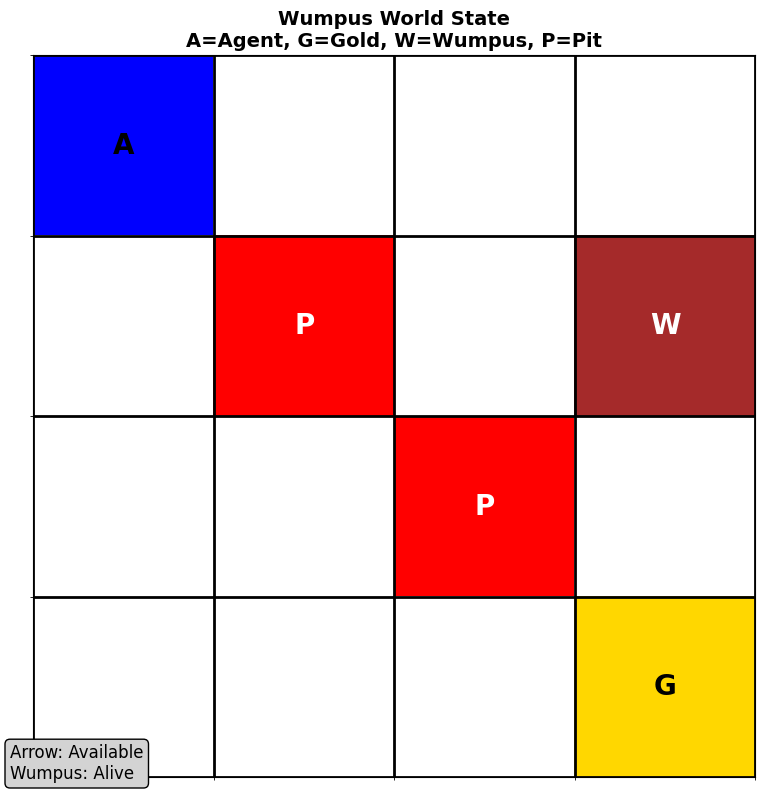


🏋️ Training Phase:
🏋️ Starting training for 10000 episodes...
Episode  100 | Avg Reward: -858.20 | Success Rate:  14.0% | ε: 0.606 | Q-states: 32
Episode  200 | Avg Reward: -384.34 | Success Rate:  34.5% | ε: 0.367 | Q-states: 40
Episode  300 | Avg Reward: -141.77 | Success Rate:  48.3% | ε: 0.222 | Q-states: 40
Episode  400 | Avg Reward:  11.63 | Success Rate:  58.5% | ε: 0.135 | Q-states: 40
Episode  500 | Avg Reward:  29.03 | Success Rate:  64.8% | ε: 0.082 | Q-states: 40
Episode  600 | Avg Reward: 118.63 | Success Rate:  70.3% | ε: 0.049 | Q-states: 40
Episode  700 | Avg Reward: 121.40 | Success Rate:  74.3% | ε: 0.030 | Q-states: 40
Episode  800 | Avg Reward: 141.76 | Success Rate:  77.5% | ε: 0.018 | Q-states: 40
Episode  900 | Avg Reward: 143.89 | Success Rate:  80.0% | ε: 0.011 | Q-states: 40
Episode 1000 | Avg Reward: 143.93 | Success Rate:  82.0% | ε: 0.010 | Q-states: 40
Episode 1100 | Avg Reward: 132.95 | Success Rate:  83.5% | ε: 0.010 | Q-states: 40
Episode 1200 | Avg Re

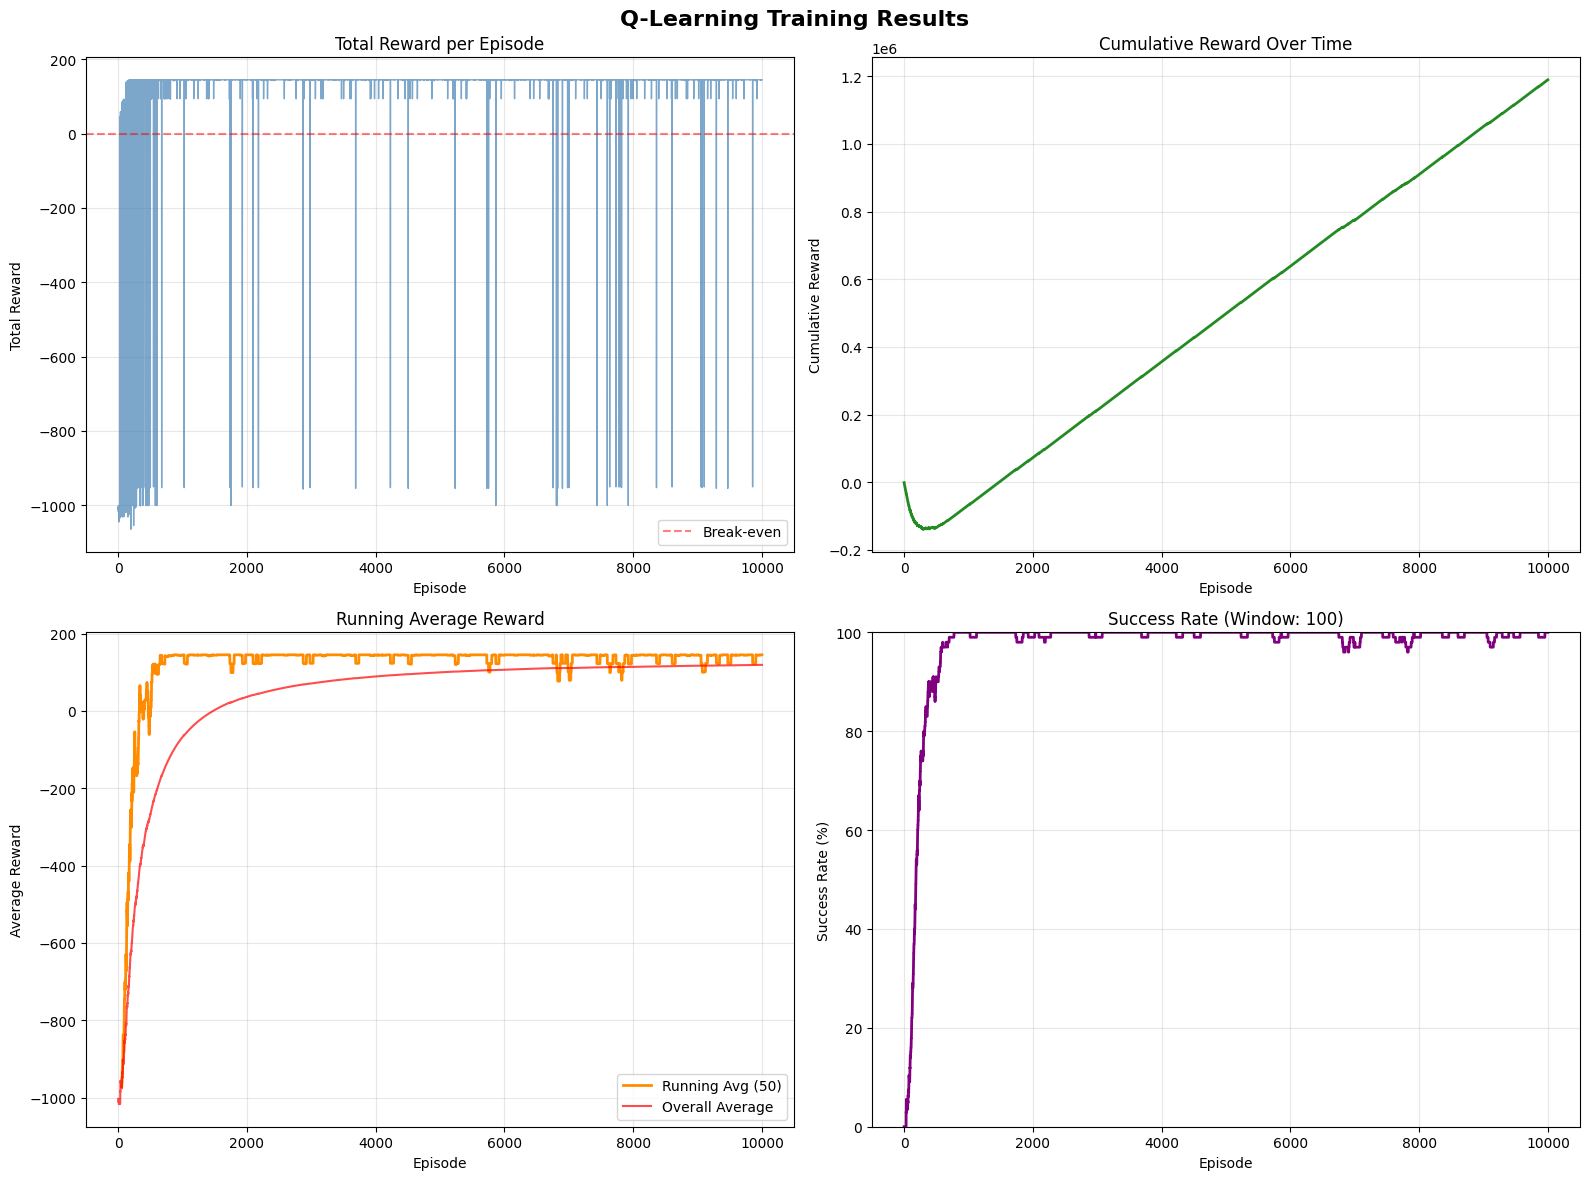


🧪 Testing Phase:
🧪 Testing trained agent...

🎮 Test Episode 1
------------------------------
Initial state:


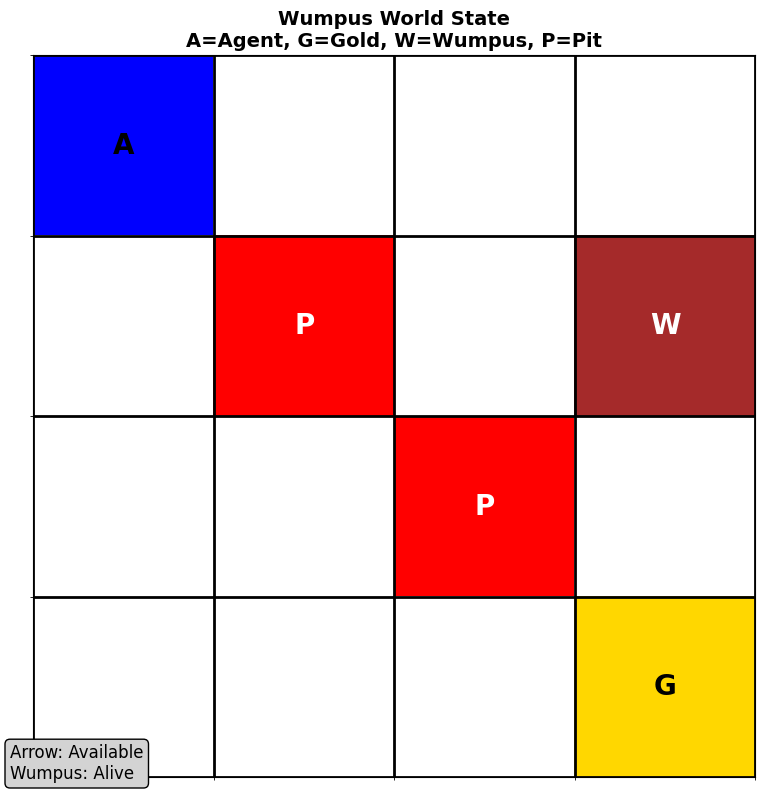

Step 1: down → Reward: -1
Step 2: shoot_right → Reward: 50
Step 3: down → Reward: -1
Step 4: right → Reward: -1
Step 5: down → Reward: -1
Step 6: right → Reward: -1
Step 7: right → Reward: 100


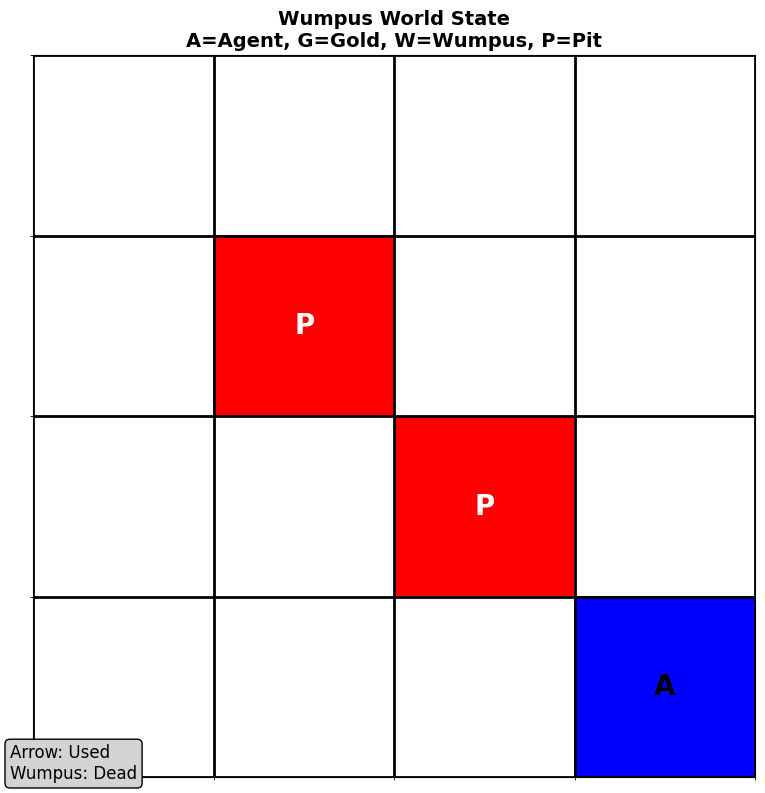

📊 Episode 1 Results:
   🎯 Total Reward: 145
   👟 Steps Taken: 7
   🎬 Actions: down → shoot_right → down → right → down → right → right
   ⏰ TIMEOUT: Ran out of time

🎮 Test Episode 2
------------------------------
Initial state:


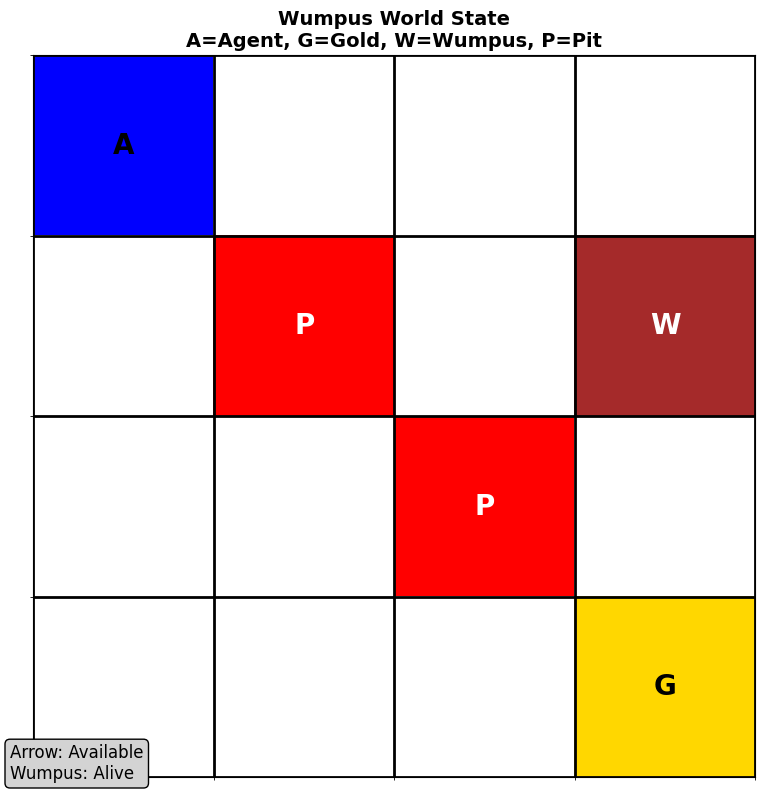

Step 1: down → Reward: -1
Step 2: shoot_right → Reward: 50
Step 3: down → Reward: -1
Step 4: right → Reward: -1
Step 5: down → Reward: -1
Step 6: right → Reward: -1
Step 7: right → Reward: 100


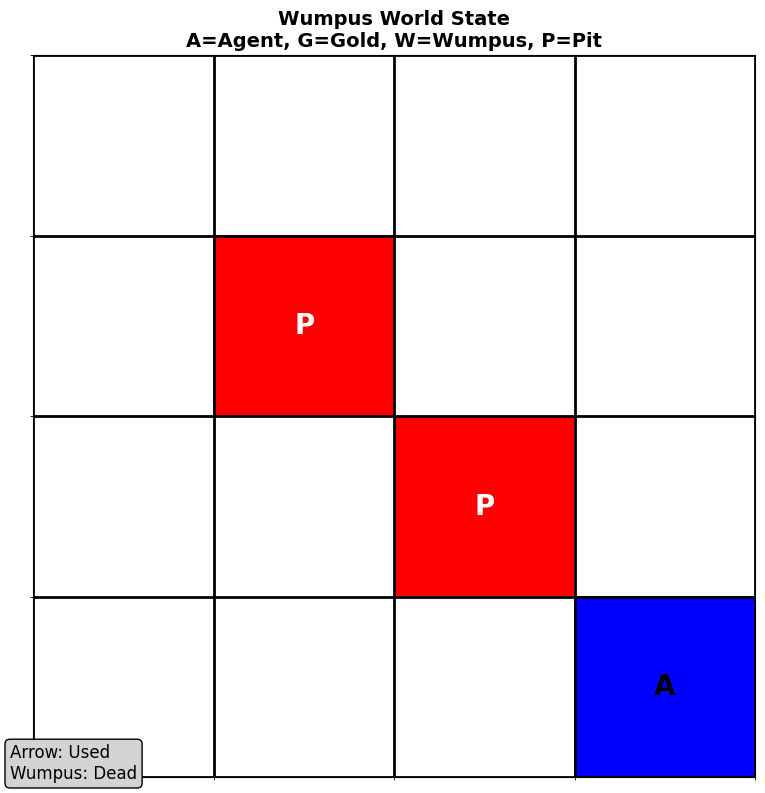

📊 Episode 2 Results:
   🎯 Total Reward: 145
   👟 Steps Taken: 7
   🎬 Actions: down → shoot_right → down → right → down → right → right
   ⏰ TIMEOUT: Ran out of time

🎮 Test Episode 3
------------------------------
Initial state:


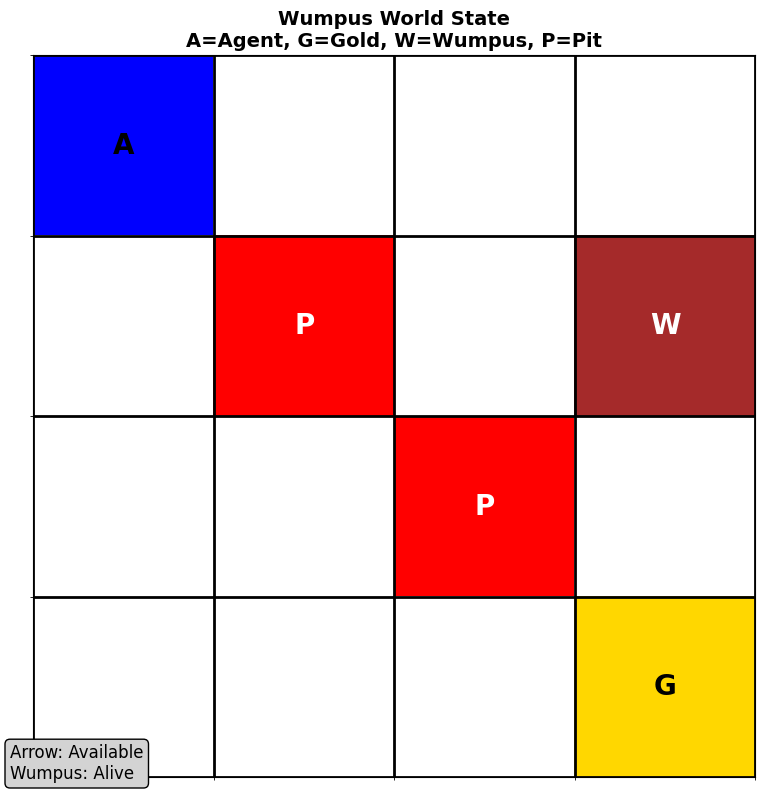

Step 1: down → Reward: -1
Step 2: shoot_right → Reward: 50
Step 3: down → Reward: -1
Step 4: right → Reward: -1
Step 5: down → Reward: -1
Step 6: right → Reward: -1
Step 7: right → Reward: 100


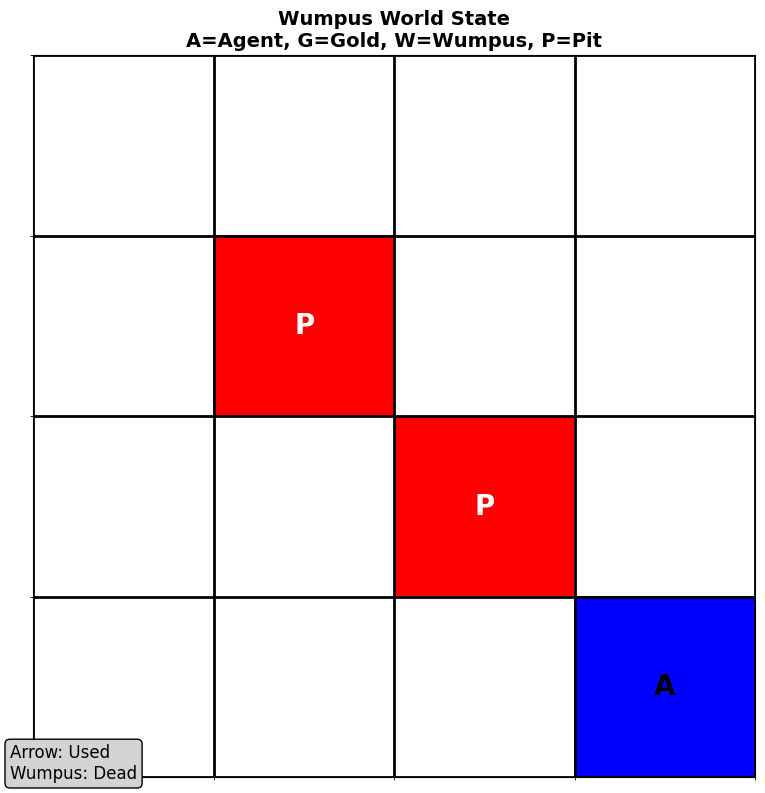

📊 Episode 3 Results:
   🎯 Total Reward: 145
   👟 Steps Taken: 7
   🎬 Actions: down → shoot_right → down → right → down → right → right
   ⏰ TIMEOUT: Ran out of time

🎮 Test Episode 4
------------------------------
Initial state:


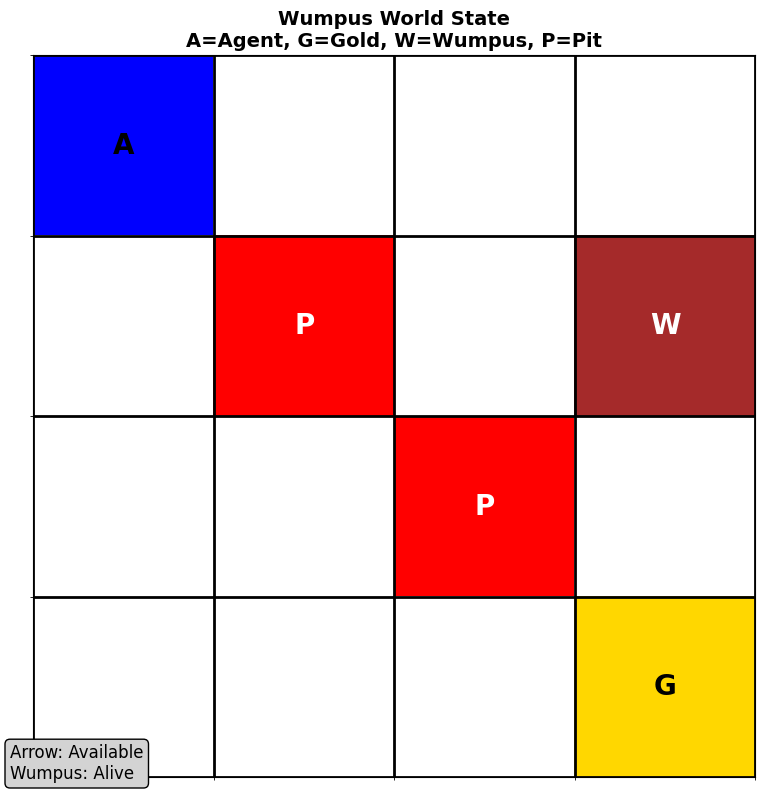

Step 1: down → Reward: -1
Step 2: shoot_right → Reward: 50
Step 3: down → Reward: -1
Step 4: right → Reward: -1
Step 5: down → Reward: -1
Step 6: right → Reward: -1
Step 7: right → Reward: 100


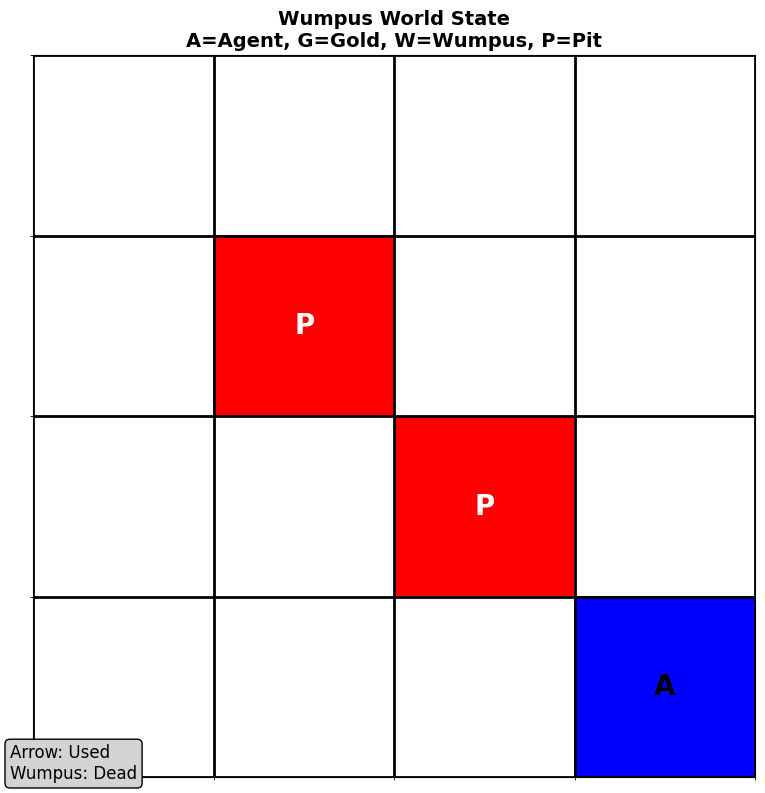

📊 Episode 4 Results:
   🎯 Total Reward: 145
   👟 Steps Taken: 7
   🎬 Actions: down → shoot_right → down → right → down → right → right
   ⏰ TIMEOUT: Ran out of time

🎮 Test Episode 5
------------------------------
Initial state:


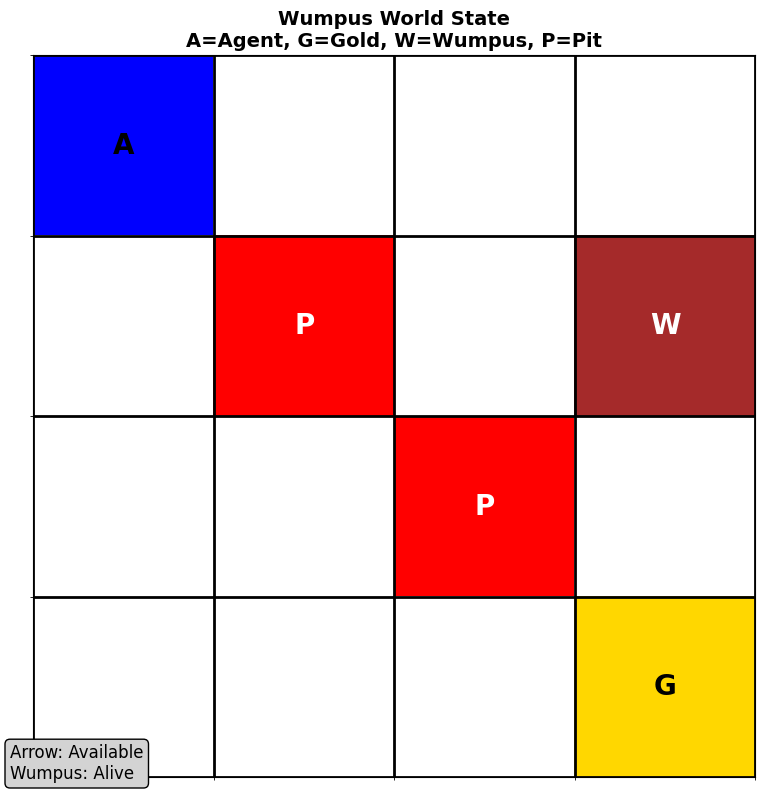

Step 1: down → Reward: -1
Step 2: shoot_right → Reward: 50
Step 3: down → Reward: -1
Step 4: right → Reward: -1
Step 5: down → Reward: -1
Step 6: right → Reward: -1
Step 7: right → Reward: 100


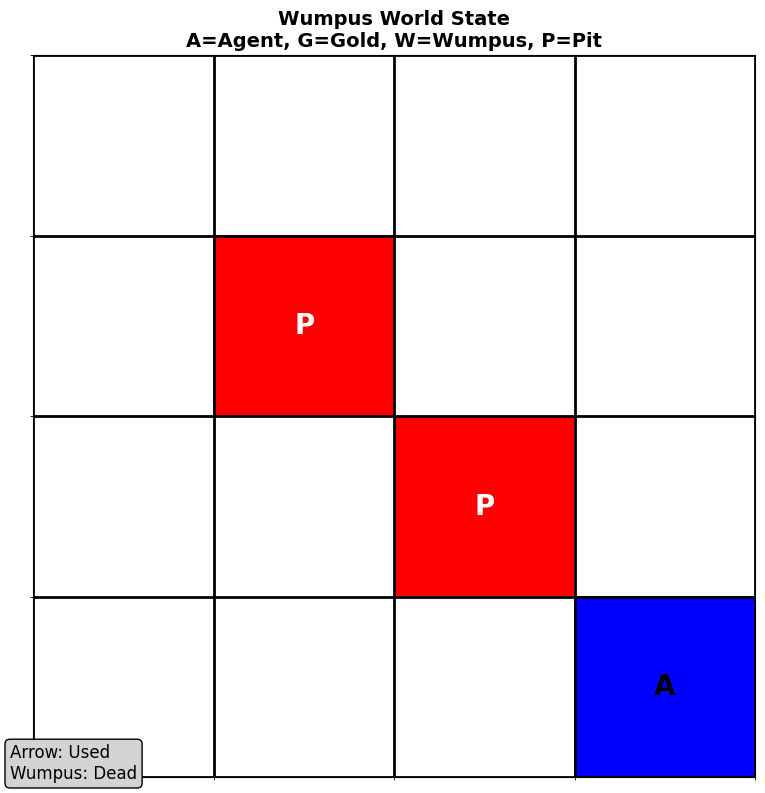

📊 Episode 5 Results:
   🎯 Total Reward: 145
   👟 Steps Taken: 7
   🎬 Actions: down → shoot_right → down → right → down → right → right
   ⏰ TIMEOUT: Ran out of time

🏆 TEST SUMMARY:
   ✅ Success Rate: 5/5 (100.0%)
   📊 Average Reward: 145.00

📊 Results DataFrame created with 10000 rows
Sample data:
   Episode  Total_Reward  Cumulative_Reward  Mean_Reward  Success
0        1         -1003              -1003 -1003.000000        0
1        2         -1012              -2015 -1007.500000        0
2        3         -1005              -3020 -1006.666667        0
3        4         -1018              -4038 -1009.500000        0
4        5         -1014              -5052 -1010.400000        0

✅ Experiment completed!
🧠 Final Q-table size: 40 states


In [ ]:
results = run_qlearning_experiment()

##DQN

### Import all necessary libraries

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

# Set up matplotlib for Colab
%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(84)
tf.random.set_seed(84)
random.seed(84)

### 2. ENVIRONMENT CLASS

In [ ]:
class GridEnvironment2:
    """Simplified Wumpus World Environment"""

    def __init__(self):
        self.grid_size = 4
        self.agent_position = [0, 0]
        self.gold_position = [3, 3]
        self.pits = [[1, 1], [2, 2]]
        self.wumpus_position = [1, 3]
        self.wumpus_alive = True
        self.arrow_available = True
        self.state_size = 96  # 4x4x6 = 96

        self.action_names = ['up', 'down', 'left', 'right',
                           'shoot_up', 'shoot_down', 'shoot_left', 'shoot_right']

        print("🌍 Environment created!")

    def reset(self):
        """Reset environment to initial state"""
        self.agent_position = [0, 0]
        self.wumpus_position = [1, 3]
        self.wumpus_alive = True
        self.arrow_available = True
        return self.get_state()

    def step(self, action):
        """Execute action and return (next_state, reward, done)"""
        reward = -1  # Movement penalty
        done = False
        x, y = self.agent_position

        # Movement actions (0-3)
        if action == 0:  # Move up
            x = max(0, x - 1)
        elif action == 1:  # Move down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Move left
            y = max(0, y - 1)
        elif action == 3:  # Move right
            y = min(self.grid_size - 1, y + 1)

        # Shooting actions (4-7)
        elif action == 4 and self.arrow_available:  # Shoot up
            self.arrow_available = False
            if (self.wumpus_position[1] == y and
                self.wumpus_position[0] < x and self.wumpus_alive):
                reward = 50
                self.wumpus_alive = False

        elif action == 5 and self.arrow_available:  # Shoot down
            self.arrow_available = False
            if (self.wumpus_position[1] == y and
                self.wumpus_position[0] > x and self.wumpus_alive):
                reward = 50
                self.wumpus_alive = False

        elif action == 6 and self.arrow_available:  # Shoot left
            self.arrow_available = False
            if (self.wumpus_position[0] == x and
                self.wumpus_position[1] < y and self.wumpus_alive):
                reward = 50
                self.wumpus_alive = False

        elif action == 7 and self.arrow_available:  # Shoot right
            self.arrow_available = False
            if (self.wumpus_position[0] == x and
                self.wumpus_position[1] > y and self.wumpus_alive):
                reward = 50
                self.wumpus_alive = False

        # Update position (only for movement)
        if action <= 3:
            self.agent_position = [x, y]

        # Check terminal conditions
        if self.agent_position == self.gold_position:
            reward = 100  # Found gold!
            done = True
        elif self.agent_position in self.pits:
            reward = -1000  # Fell in pit
            done = True
        elif (self.agent_position == self.wumpus_position and self.wumpus_alive):
            reward = -1000  # Eaten by Wumpus
            done = True

        return self.get_state(), reward, done

    def get_state(self):
        """Return state as flattened vector (96 dimensions)"""
        state = np.zeros((self.grid_size, self.grid_size, 6), dtype=np.float32)

        # Channel 0: Agent position
        state[self.agent_position[0], self.agent_position[1], 0] = 1.0

        # Channel 1: Gold position
        state[self.gold_position[0], self.gold_position[1], 1] = 1.0

        # Channel 2: Wumpus position (only if alive)
        if self.wumpus_alive:
            state[self.wumpus_position[0], self.wumpus_position[1], 2] = 1.0

        # Channel 3: Pits
        for pit in self.pits:
            state[pit[0], pit[1], 3] = 1.0

        # Channel 4: Arrow availability
        state[:, :, 4] = float(self.arrow_available)

        # Channel 5: Wumpus alive status
        state[:, :, 5] = float(self.wumpus_alive)

        return state.flatten()

    def visualize(self):
        """Simple visualization of the current state"""
        print(f"\n🎮 Current State:")
        print(f"  Agent: {self.agent_position}")
        print(f"  Gold: {self.gold_position}")
        print(f"  Wumpus: {self.wumpus_position} ({'Alive' if self.wumpus_alive else 'Dead'})")
        print(f"  Pits: {self.pits}")
        print(f"  Arrow: {'Available' if self.arrow_available else 'Used'}")

print("✅ Environment class created!")

✅ Environment class created!


### 3. REPLAY MEMORY CLASS

In [ ]:
class SimpleReplayMemory:
    """Simple experience replay buffer"""

    def __init__(self, capacity=1000):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        print(f"🧠 Replay Memory created with capacity: {capacity}")

    def push(self, state, action, reward, next_state, done):
        """Save experience in buffer"""
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """Sample random batch of experiences"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)

print("✅ Simple Replay Memory created!")

✅ Simple Replay Memory created!


### 4. DQN AGENT CLASS


In [ ]:
class SimplifiedDQNAgent:
    """
    Simplified DQN Agent - Fast Training

    Architecture: Input(96) → Dense(32) → Output(8)
    Only ~3000 parameters!
    """

    def __init__(self, env, learning_rate=0.01, gamma=0.95,
                 epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.98):
        self.env = env
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.state_size = env.state_size
        self.action_size = 8
        self.batch_size = 8

        # Simple replay memory
        self.memory = SimpleReplayMemory(capacity=1000)

        # Build simple neural networks
        self.q_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_network()

        print("🤖 Simplified DQN Agent Created!")
        print(f"🧠 Network: {self.state_size} → 32 → {self.action_size}")
        print(f"📊 Parameters: ~{self.q_network.count_params()}")

    def _build_model(self):
        """Build ultra-simple neural network"""
        model = keras.Sequential([
            Dense(32, activation='relu', input_shape=(self.state_size,)),
            Dense(self.action_size, activation='linear')
        ])

        model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='mse'
        )

        return model

    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.set_weights(self.q_network.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.push(state, action, reward, next_state, done)

    def act(self, state):
        """Choose action using epsilon-greedy policy"""
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        state = np.reshape(state, [1, self.state_size])
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        """Train the network on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return

        # Sample batch from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Predict Q-values for current and next states
        current_q_values = self.q_network.predict(states, verbose=0)
        next_q_values = self.target_network.predict(next_states, verbose=0)

        # Update Q-values
        for i in range(self.batch_size):
            if dones[i]:
                current_q_values[i][actions[i]] = rewards[i]
            else:
                current_q_values[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

        # Train the network
        self.q_network.fit(states, current_q_values, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

    def train(self, episodes=1000):
        """Train the agent"""
        scores = []

        print(f"🏋️ Training Simplified DQN for {episodes} episodes...")
        print("=" * 50)

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            steps = 0
            max_steps = 50

            while steps < max_steps:
                action = self.act(state)
                next_state, reward, done = self.env.step(action)

                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                steps += 1

                if done:
                    break

                # Train every step
                if steps % 2 == 0:
                    self.replay()

            scores.append(total_reward)

            # Update target network every 20 episodes
            if episode % 20 == 0:
                self.update_target_network()

            # Print progress
            if episode % 100 == 0 or episode == episodes - 1:
                avg_score = np.mean(scores[-50:])
                success_rate = sum(1 for s in scores[-50:] if s > 0) / len(scores[-50:]) * 100
                print(f"Episode {episode:4d} | "
                      f"Score: {total_reward:6.1f} | "
                      f"Avg: {avg_score:6.1f} | "
                      f"Success: {success_rate:4.1f}% | "
                      f"ε: {self.epsilon:.3f}")

        print("=" * 50)
        print("🎉 Training completed!")
        return scores

print("✅ Simplified DQN Agent created!")

✅ Simplified DQN Agent created!


### 5. VISUALIZATION FUNCTIONS

In [ ]:
def plot_training_results(scores, title="Simplified DQN Training Results"):
    """Plot training results"""
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot 1: Episode scores
    axs[0, 0].plot(scores, alpha=0.7)
    axs[0, 0].set_title('Episode Scores')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Score')
    axs[0, 0].grid(True)

    # Plot 2: Moving average
    window = 50
    if len(scores) >= window:
        moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')
        axs[0, 1].plot(moving_avg)
        axs[0, 1].set_title(f'Moving Average (window={window})')
        axs[0, 1].set_xlabel('Episode')
        axs[0, 1].set_ylabel('Average Score')
        axs[0, 1].grid(True)

    # Plot 3: Cumulative rewards
    cumulative = np.cumsum(scores)
    axs[1, 0].plot(cumulative)
    axs[1, 0].set_title('Cumulative Rewards')
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Cumulative Reward')
    axs[1, 0].grid(True)

    # Plot 4: Success rate
    success_rate = []
    window_size = 50
    for i in range(len(scores)):
        start = max(0, i - window_size + 1)
        window_scores = scores[start:i+1]
        successes = sum(1 for s in window_scores if s > 0)
        success_rate.append(successes / len(window_scores) * 100)

    axs[1, 1].plot(success_rate)
    axs[1, 1].set_title('Success Rate')
    axs[1, 1].set_xlabel('Episode')
    axs[1, 1].set_ylabel('Success Rate (%)')
    axs[1, 1].grid(True)
    axs[1, 1].set_ylim(0, 100)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def print_summary(scores):
    """Print training summary"""
    print("\n📊 TRAINING SUMMARY")
    print("=" * 30)
    print(f"Total Episodes: {len(scores)}")
    print(f"Average Score: {np.mean(scores):.2f}")
    print(f"Best Score: {max(scores)}")
    print(f"Worst Score: {min(scores)}")
    print(f"Success Rate: {sum(1 for s in scores if s > 0) / len(scores) * 100:.1f}%")
    print(f"Final 100 Episodes Average: {np.mean(scores[-100:]):.2f}")
    print("=" * 30)

print("✅ Visualization functions created!")

✅ Visualization functions created!


### 6. TESTING FUNCTIONS

In [ ]:
def test_agent(agent, env, num_episodes=5):
    """Test the trained agent"""
    print("🧪 Testing trained agent...")

    # Disable exploration for testing
    old_epsilon = agent.epsilon
    agent.epsilon = 0

    test_scores = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        max_steps = 50

        print(f"\n🎮 Test Episode {episode + 1}")
        env.visualize()

        while steps < max_steps:
            action = agent.act(state)
            next_state, reward, done = env.step(action)

            print(f"  Step {steps + 1}: {env.action_names[action]} → Reward: {reward}")

            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        test_scores.append(total_reward)
        print(f"  Final Score: {total_reward}")

        if total_reward > 0:
            print("  ✅ SUCCESS!")
        else:
            print("  ❌ FAILED")

    # Restore epsilon
    agent.epsilon = old_epsilon

    avg_score = np.mean(test_scores)
    success_rate = sum(1 for s in test_scores if s > 0) / len(test_scores) * 100

    print(f"\n🏆 Test Results:")
    print(f"  Average Score: {avg_score:.2f}")
    print(f"  Success Rate: {success_rate:.1f}%")

    return test_scores

print("✅ Testing function created!")


✅ Testing function created!


### 7. MAIN TRAINING SCRIPT

In [ ]:
def run_simplified_dqn_experiment():
    """Run the complete simplified DQN experiment"""
    print("🚀 Starting Simplified DQN Experiment!")
    print("=" * 50)

    # Create environment and agent
    env = GridEnvironment2()
    agent = SimplifiedDQNAgent(env)

    # Show initial state
    print("\n🌍 Initial Environment:")
    env.visualize()

    # Show network architecture
    print("\n🧠 Network Architecture:")
    agent.q_network.summary()

    # Train the agent
    print("\n🏋️ Training Phase:")
    scores = agent.train(episodes=1000)

    # Show results
    print_summary(scores)
    plot_training_results(scores)

    # Test the agent
    print("\n🧪 Testing Phase:")
    test_scores = test_agent(agent, env, num_episodes=5)

    # Create results dataframe
    results_df = pd.DataFrame({
        'Episode': range(1, len(scores) + 1),
        'Score': scores,
        'Cumulative_Score': np.cumsum(scores),
        'Success': [1 if s > 0 else 0 for s in scores]
    })

    print(f"\n📊 Results saved to DataFrame with {len(results_df)} rows")
    print("First few rows:")
    print(results_df.head())

    return {
        'agent': agent,
        'env': env,
        'training_scores': scores,
        'test_scores': test_scores,
        'results_df': results_df
    }

print("✅ Main experiment function ready!")
print("\n🎯 To run the experiment:")
print("results = run_simplified_dqn_experiment()")

✅ Main experiment function ready!

🎯 To run the experiment:
results = run_simplified_dqn_experiment()


### 8. ADVANCED ANALYSIS FUNCTIONS

In [ ]:
def analyze_q_values(agent, env):
    """Analyze Q-values for different states"""
    print("🔍 ANALYZING Q-VALUES")
    print("=" * 40)

    # Test different game states
    test_scenarios = [
        ("Initial State", [0, 0], [1, 3], True, True),
        ("Near Gold", [3, 2], [1, 3], True, True),
        ("Near Wumpus", [1, 2], [1, 3], True, True),
        ("Near Pit", [1, 0], [1, 3], True, True),
        ("Wumpus Dead", [2, 2], [1, 3], False, False),
        ("No Arrow", [2, 1], [1, 3], True, False),
    ]

    for scenario, agent_pos, wumpus_pos, wumpus_alive, arrow_available in test_scenarios:
        # Set up environment
        env.agent_position = agent_pos
        env.wumpus_position = wumpus_pos
        env.wumpus_alive = wumpus_alive
        env.arrow_available = arrow_available

        state = env.get_state()
        state_input = np.reshape(state, [1, env.state_size])
        q_values = agent.q_network.predict(state_input, verbose=0)[0]

        print(f"\n📍 {scenario} - Agent at {agent_pos}:")
        for i, (action, q_val) in enumerate(zip(env.action_names, q_values)):
            print(f"   {action:12s}: {q_val:8.3f}")

        best_action = np.argmax(q_values)
        print(f"   🎯 Best action: {env.action_names[best_action]} (Q={q_values[best_action]:.3f})")

def analyze_action_distribution(agent, env, num_episodes=100):
    """Analyze action distribution and preferences"""
    print("\n📊 ANALYZING ACTION DISTRIBUTION")
    print("=" * 40)

    # Disable exploration for analysis
    old_epsilon = agent.epsilon
    agent.epsilon = 0

    action_counts = np.zeros(8)
    action_rewards = np.zeros(8)

    for episode in range(num_episodes):
        state = env.reset()
        steps = 0
        max_steps = 50

        while steps < max_steps:
            action = agent.act(state)
            next_state, reward, done = env.step(action)

            action_counts[action] += 1
            action_rewards[action] += reward

            state = next_state
            steps += 1

            if done:
                break

    # Restore epsilon
    agent.epsilon = old_epsilon

    # Calculate statistics
    total_actions = np.sum(action_counts)
    action_percentages = action_counts / total_actions * 100
    avg_rewards = np.divide(action_rewards, action_counts,
                           out=np.zeros_like(action_rewards), where=action_counts!=0)

    print(f"\nAction Distribution (over {num_episodes} episodes):")
    print(f"{'Action':12s} {'Count':>8s} {'%':>8s} {'Avg Reward':>12s}")
    print("-" * 45)

    for i, action_name in enumerate(env.action_names):
        print(f"{action_name:12s} {action_counts[i]:8.0f} {action_percentages[i]:7.1f}% {avg_rewards[i]:11.3f}")

    # Visualize action distribution
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.bar(env.action_names, action_percentages)
    plt.title('Action Distribution (%)')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.bar(env.action_names, avg_rewards)
    plt.title('Average Reward per Action')
    plt.ylabel('Average Reward')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_learning_progression(scores, window=100):
    """Analyze learning progression over time"""
    print("\n📈 ANALYZING LEARNING PROGRESSION")
    print("=" * 40)

    if len(scores) < window:
        window = len(scores) // 2

    # Calculate metrics over time
    early_scores = scores[:window]
    late_scores = scores[-window:]

    early_avg = np.mean(early_scores)
    late_avg = np.mean(late_scores)
    improvement = late_avg - early_avg

    early_success = sum(1 for s in early_scores if s > 0) / len(early_scores) * 100
    late_success = sum(1 for s in late_scores if s > 0) / len(late_scores) * 100
    success_improvement = late_success - early_success

    print(f"Early Episodes (1-{window}):")
    print(f"   Average Score: {early_avg:.2f}")
    print(f"   Success Rate: {early_success:.1f}%")
    print(f"   Best Score: {max(early_scores)}")

    print(f"\nLate Episodes ({len(scores)-window+1}-{len(scores)}):")
    print(f"   Average Score: {late_avg:.2f}")
    print(f"   Success Rate: {late_success:.1f}%")
    print(f"   Best Score: {max(late_scores)}")

    print(f"\nImprovement:")
    print(f"   Score Improvement: {improvement:+.2f}")
    print(f"   Success Rate Improvement: {success_improvement:+.1f}%")

    # Learning stability analysis
    rolling_std = pd.Series(scores).rolling(window=window).std()
    early_stability = np.mean(rolling_std[:window])
    late_stability = np.mean(rolling_std[-window:])

    print(f"   Stability (lower is better): {early_stability:.2f} → {late_stability:.2f}")

    # Visualize learning progression
    plt.figure(figsize=(15, 10))

    # Plot 1: Score progression with trend
    plt.subplot(2, 3, 1)
    plt.plot(scores, alpha=0.5, label='Episode Score')
    z = np.polyfit(range(len(scores)), scores, 1)
    p = np.poly1d(z)
    plt.plot(range(len(scores)), p(range(len(scores))), "r--", alpha=0.8, label='Trend')
    plt.title('Score Progression with Trend')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Moving average
    plt.subplot(2, 3, 2)
    moving_avg = pd.Series(scores).rolling(window=window//2).mean()
    plt.plot(moving_avg)
    plt.title(f'Moving Average (window={window//2})')
    plt.xlabel('Episode')
    plt.ylabel('Average Score')
    plt.grid(True, alpha=0.3)

    # Plot 3: Rolling standard deviation
    plt.subplot(2, 3, 3)
    plt.plot(rolling_std)
    plt.title('Learning Stability (Rolling Std)')
    plt.xlabel('Episode')
    plt.ylabel('Standard Deviation')
    plt.grid(True, alpha=0.3)

    # Plot 4: Success rate over time
    plt.subplot(2, 3, 4)
    success_rate = []
    for i in range(len(scores)):
        start = max(0, i - window//2 + 1)
        window_scores = scores[start:i+1]
        successes = sum(1 for s in window_scores if s > 0)
        success_rate.append(successes / len(window_scores) * 100)

    plt.plot(success_rate)
    plt.title('Success Rate Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate (%)')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)

    # Plot 5: Score distribution comparison
    plt.subplot(2, 3, 5)
    plt.hist(early_scores, alpha=0.5, bins=20, label='Early Episodes')
    plt.hist(late_scores, alpha=0.5, bins=20, label='Late Episodes')
    plt.title('Score Distribution Comparison')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 6: Performance metrics
    plt.subplot(2, 3, 6)
    metrics = ['Average Score', 'Success Rate', 'Best Score']
    early_metrics = [early_avg, early_success, max(early_scores)]
    late_metrics = [late_avg, late_success, max(late_scores)]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, early_metrics, width, label='Early Episodes', alpha=0.7)
    plt.bar(x + width/2, late_metrics, width, label='Late Episodes', alpha=0.7)
    plt.title('Performance Metrics Comparison')
    plt.xticks(x, metrics)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_network_behavior(agent, env):
    """Analyze neural network behavior and decision making"""
    print("\n🧠 ANALYZING NETWORK BEHAVIOR")
    print("=" * 40)

    # Analyze network weights
    weights = agent.q_network.get_weights()

    print("Network Architecture Analysis:")
    print(f"   Layer 1 (Input → Hidden): {weights[0].shape}")
    print(f"   Layer 2 (Hidden → Output): {weights[2].shape}")
    print(f"   Total Parameters: {agent.q_network.count_params()}")

    # Weight statistics
    print(f"\nWeight Statistics:")
    print(f"   Layer 1 weights - Mean: {np.mean(weights[0]):.4f}, Std: {np.std(weights[0]):.4f}")
    print(f"   Layer 2 weights - Mean: {np.mean(weights[2]):.4f}, Std: {np.std(weights[2]):.4f}")

    # Visualize weight distributions
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(weights[0].flatten(), bins=30, alpha=0.7)
    plt.title('Layer 1 Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.hist(weights[2].flatten(), bins=30, alpha=0.7)
    plt.title('Layer 2 Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.imshow(weights[2].T, cmap='coolwarm', aspect='auto')
    plt.title('Output Layer Weights Heatmap')
    plt.xlabel('Hidden Units')
    plt.ylabel('Actions')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

def analyze_exploration_exploitation(agent, env, num_episodes=200):
    """Analyze exploration vs exploitation behavior"""
    print("\n🎯 ANALYZING EXPLORATION VS EXPLOITATION")
    print("=" * 40)

    # Test different epsilon values
    epsilon_values = [0.0, 0.1, 0.3, 0.5, 1.0]
    results = {}

    original_epsilon = agent.epsilon

    for epsilon in epsilon_values:
        agent.epsilon = epsilon
        episode_scores = []

        for episode in range(num_episodes):
            state = env.reset()
            total_reward = 0
            steps = 0
            max_steps = 50

            while steps < max_steps:
                action = agent.act(state)
                next_state, reward, done = env.step(action)
                state = next_state
                total_reward += reward
                steps += 1

                if done:
                    break

            episode_scores.append(total_reward)

        results[epsilon] = {
            'scores': episode_scores,
            'average': np.mean(episode_scores),
            'success_rate': sum(1 for s in episode_scores if s > 0) / len(episode_scores) * 100,
            'std': np.std(episode_scores)
        }

    # Restore original epsilon
    agent.epsilon = original_epsilon

    # Print results
    print(f"Exploration vs Exploitation Analysis ({num_episodes} episodes each):")
    print(f"{'Epsilon':>8s} {'Avg Score':>12s} {'Success Rate':>14s} {'Std Dev':>10s}")
    print("-" * 50)

    for epsilon, result in results.items():
        print(f"{epsilon:8.1f} {result['average']:12.2f} {result['success_rate']:13.1f}% {result['std']:10.2f}")

    # Visualize results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    epsilons = list(results.keys())
    averages = [results[e]['average'] for e in epsilons]
    plt.plot(epsilons, averages, 'o-')
    plt.title('Average Score vs Epsilon')
    plt.xlabel('Epsilon (Exploration Rate)')
    plt.ylabel('Average Score')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    success_rates = [results[e]['success_rate'] for e in epsilons]
    plt.plot(epsilons, success_rates, 'o-', color='green')
    plt.title('Success Rate vs Epsilon')
    plt.xlabel('Epsilon (Exploration Rate)')
    plt.ylabel('Success Rate (%)')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    stds = [results[e]['std'] for e in epsilons]
    plt.plot(epsilons, stds, 'o-', color='red')
    plt.title('Performance Stability vs Epsilon')
    plt.xlabel('Epsilon (Exploration Rate)')
    plt.ylabel('Standard Deviation')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results

def analyze_convergence(scores, window=50):
    """Analyze convergence characteristics"""
    print("\n📈 ANALYZING CONVERGENCE")
    print("=" * 40)

    # Calculate moving statistics
    moving_avg = pd.Series(scores).rolling(window=window).mean()
    moving_std = pd.Series(scores).rolling(window=window).std()

    # Find convergence point (where moving average stabilizes)
    if len(moving_avg) > window:
        differences = np.abs(np.diff(moving_avg[window:]))
        convergence_threshold = 0.5
        convergence_point = None

        for i in range(len(differences) - 20):
            if np.mean(differences[i:i+20]) < convergence_threshold:
                convergence_point = i + window
                break

        if convergence_point:
            print(f"Convergence Point: Episode {convergence_point}")
            print(f"Score at convergence: {moving_avg.iloc[convergence_point]:.2f}")
            print(f"Final 100 episodes average: {np.mean(scores[-100:]):.2f}")
        else:
            print("No clear convergence point found")

    # Analyze training phases
    total_episodes = len(scores)
    phase1 = scores[:total_episodes//3]  # Learning phase
    phase2 = scores[total_episodes//3:2*total_episodes//3]  # Improvement phase
    phase3 = scores[2*total_episodes//3:]  # Stabilization phase

    print(f"\nTraining Phase Analysis:")
    print(f"Phase 1 (Episodes 1-{len(phase1)}): Avg = {np.mean(phase1):.2f}")
    print(f"Phase 2 (Episodes {len(phase1)+1}-{len(phase1)+len(phase2)}): Avg = {np.mean(phase2):.2f}")
    print(f"Phase 3 (Episodes {len(phase1)+len(phase2)+1}-{total_episodes}): Avg = {np.mean(phase3):.2f}")

    # Visualize convergence
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(scores, alpha=0.5, label='Episode Score')
    plt.plot(moving_avg, label=f'Moving Average (window={window})')
    if convergence_point:
        plt.axvline(x=convergence_point, color='red', linestyle='--',
                   label=f'Convergence Point (Episode {convergence_point})')
    plt.title('Convergence Analysis')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 2)
    plt.plot(moving_std)
    plt.title('Learning Stability Over Time')
    plt.xlabel('Episode')
    plt.ylabel('Moving Standard Deviation')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    if len(moving_avg) > window:
        plt.plot(differences)
        plt.axhline(y=convergence_threshold, color='red', linestyle='--',
                   label=f'Convergence Threshold ({convergence_threshold})')
        plt.title('Rate of Change in Moving Average')
        plt.xlabel('Episode')
        plt.ylabel('Absolute Difference')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    phase_avgs = [np.mean(phase1), np.mean(phase2), np.mean(phase3)]
    plt.bar(['Phase 1\n(Learning)', 'Phase 2\n(Improvement)', 'Phase 3\n(Stabilization)'],
            phase_avgs, alpha=0.7)
    plt.title('Training Phase Comparison')
    plt.ylabel('Average Score')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def comprehensive_analysis(results):
    """Run all advanced analyses"""
    print("🔬 COMPREHENSIVE ANALYSIS")
    print("=" * 50)

    agent = results['agent']
    env = results['env']
    scores = results['training_scores']

    # Run all analyses
    analyze_q_values(agent, env)
    analyze_action_distribution(agent, env)
    analyze_learning_progression(scores)
    analyze_network_behavior(agent, env)
    exploration_results = analyze_exploration_exploitation(agent, env)
    analyze_convergence(scores)

    return {
        'q_values': 'completed',
        'action_distribution': 'completed',
        'learning_progression': 'completed',
        'network_behavior': 'completed',
        'exploration_exploitation': exploration_results,
        'convergence': 'completed'
    }

print("✅ Advanced analysis functions created!")



✅ Advanced analysis functions created!


🚀 Starting Simplified DQN Experiment!
🌍 Environment created!
🧠 Replay Memory created with capacity: 1000
🤖 Simplified DQN Agent Created!
🧠 Network: 96 → 32 → 8
📊 Parameters: ~3368

🌍 Initial Environment:

🎮 Current State:
  Agent: [0, 0]
  Gold: [3, 3]
  Wumpus: [1, 3] (Alive)
  Pits: [[1, 1], [2, 2]]
  Arrow: Available

🧠 Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,368 (13.16 KB)

 Trainable params: 3,368 (13.16 KB)

 Non-trainable params: 0 (0.00 B)


🏋️ Training Phase:
🏋️ Training Simplified DQN for 1000 episodes...
Episode    0 | Score: -1030.0 | Avg: -1030.0 | Success:  0.0% | ε: 0.785
Episode  100 | Score:  -50.0 | Avg: -128.2 | Success:  0.0% | ε: 0.049
Episode  200 | Score:  -50.0 | Avg: -106.0 | Success:  4.0% | ε: 0.049
Episode  300 | Score:  -50.0 | Avg: -141.1 | Success: 10.0% | ε: 0.049
Episode  400 | Score:  -50.0 | Avg: -184.5 | Success:  4.0% | ε: 0.049
Episode  500 | Score:  -50.0 | Avg: -225.7 | Success:  2.0% | ε: 0.049
Episode  600 | Score:  -50.0 | Avg:  -57.1 | Success: 22.0% | ε: 0.049
Episode  700 | Score:    1.0 | Avg: -163.9 | Success: 68.0% | ε: 0.049
Episode  800 | Score:  -50.0 | Avg:  -38.5 | Success: 60.0% | ε: 0.049
Episode  900 | Score: -1010.0 | Avg: -245.8 | Success:  0.0% | ε: 0.049
Episode  999 | Score:  -50.0 | Avg: -108.2 | Success:  0.0% | ε: 0.049
🎉 Training completed!

📊 TRAINING SUMMARY
Total Episodes: 1000
Average Score: -149.89
Best Score: 1
Worst Score: -1049
Success Rate: 16.2%
Final 100

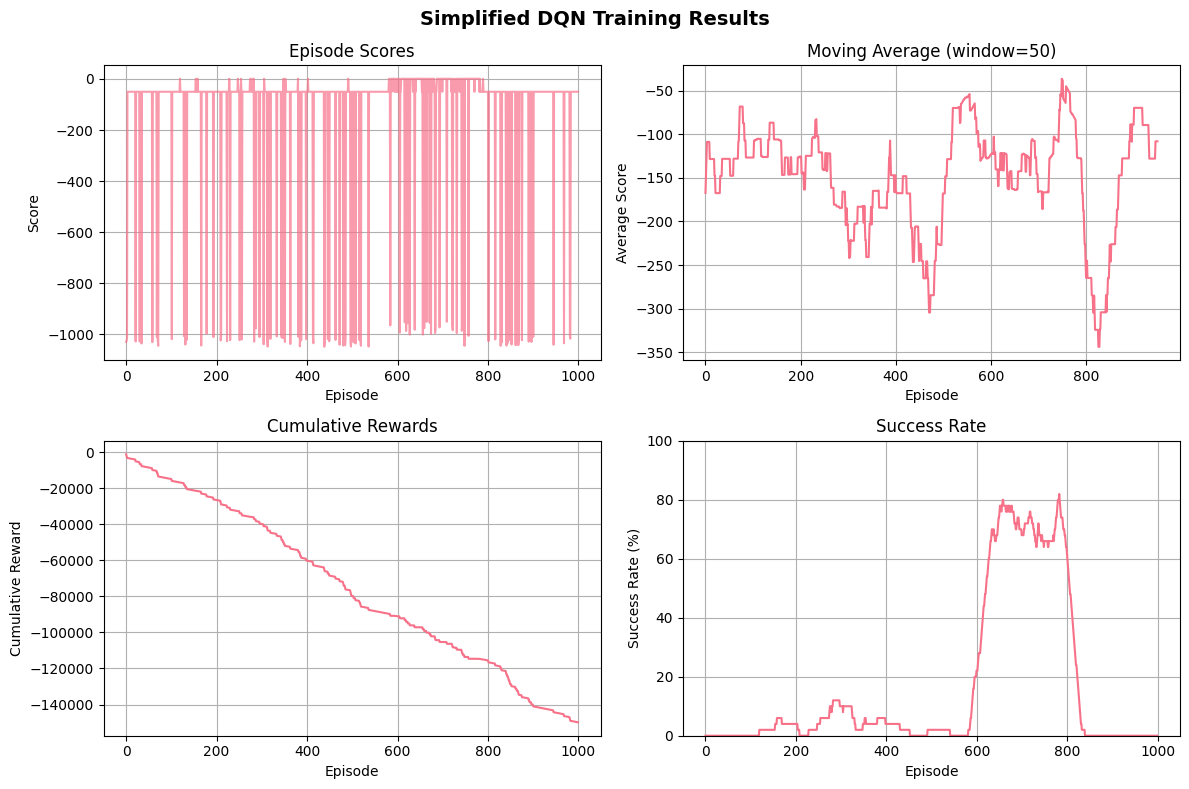


🧪 Testing Phase:
🧪 Testing trained agent...

🎮 Test Episode 1

🎮 Current State:
  Agent: [0, 0]
  Gold: [3, 3]
  Wumpus: [1, 3] (Alive)
  Pits: [[1, 1], [2, 2]]
  Arrow: Available
  Step 1: down → Reward: -1
  Step 2: up → Reward: -1
  Step 3: down → Reward: -1
  Step 4: up → Reward: -1
  Step 5: down → Reward: -1
  Step 6: up → Reward: -1
  Step 7: down → Reward: -1
  Step 8: up → Reward: -1
  Step 9: down → Reward: -1
  Step 10: up → Reward: -1
  Step 11: down → Reward: -1
  Step 12: up → Reward: -1
  Step 13: down → Reward: -1
  Step 14: up → Reward: -1
  Step 15: down → Reward: -1
  Step 16: up → Reward: -1
  Step 17: down → Reward: -1
  Step 18: up → Reward: -1
  Step 19: down → Reward: -1
  Step 20: up → Reward: -1
  Step 21: down → Reward: -1
  Step 22: up → Reward: -1
  Step 23: down → Reward: -1
  Step 24: up → Reward: -1
  Step 25: down → Reward: -1
  Step 26: up → Reward: -1
  Step 27: down → Reward: -1
  Step 28: up → Reward: -1
  Step 29: down → Reward: -1
  Step 30: up →

In [ ]:
#  run basic experiment:
results = run_simplified_dqn_experiment()


In [ ]:
# Uncomment to run with advanced analysis:
# results = run_enhanced_experiment()

## Q3 part b

✅ Comparison functions ready!

This will:
• Train both agents for exactly 1000 episodes
• Compare average rewards per episode
• Analyze performance improvement over time
• Determine which algorithm performed better
• Provide statistical significance testing
• Create comprehensive visualizations
• Save results to CSV file
🚀 RUNNING COMPLETE COMPARISON FOR QUESTION 2
🎯 Policy Performance: Q-Learning vs DQN after 1000 episodes
🔬 QUESTION 2: POLICY PERFORMANCE COMPARISON
🎯 Comparing Q-Learning vs DQN after 1000 episodes
🧠 Training Q-Learning Agent for 1000 episodes...
🌍 Wumpus World Environment Created!
📍 Agent starts at: [0, 0]
🏆 Gold location: [3, 3]
👹 Wumpus location: [1, 3]
🕳️ Pit locations: [[1, 1], [2, 2]]
🤖 Q-Learning Agent Created!
📚 Learning Rate: 0.1
🔮 Discount Factor: 0.9
🎲 Initial Exploration: 1.0
🏋️ Starting training for 1000 episodes...
Episode  100 | Avg Reward: -899.04 | Success Rate:  10.0% | ε: 0.606 | Q-states: 35
Episode  200 | Avg Reward: -427.19 | Success Rate:  30.5%

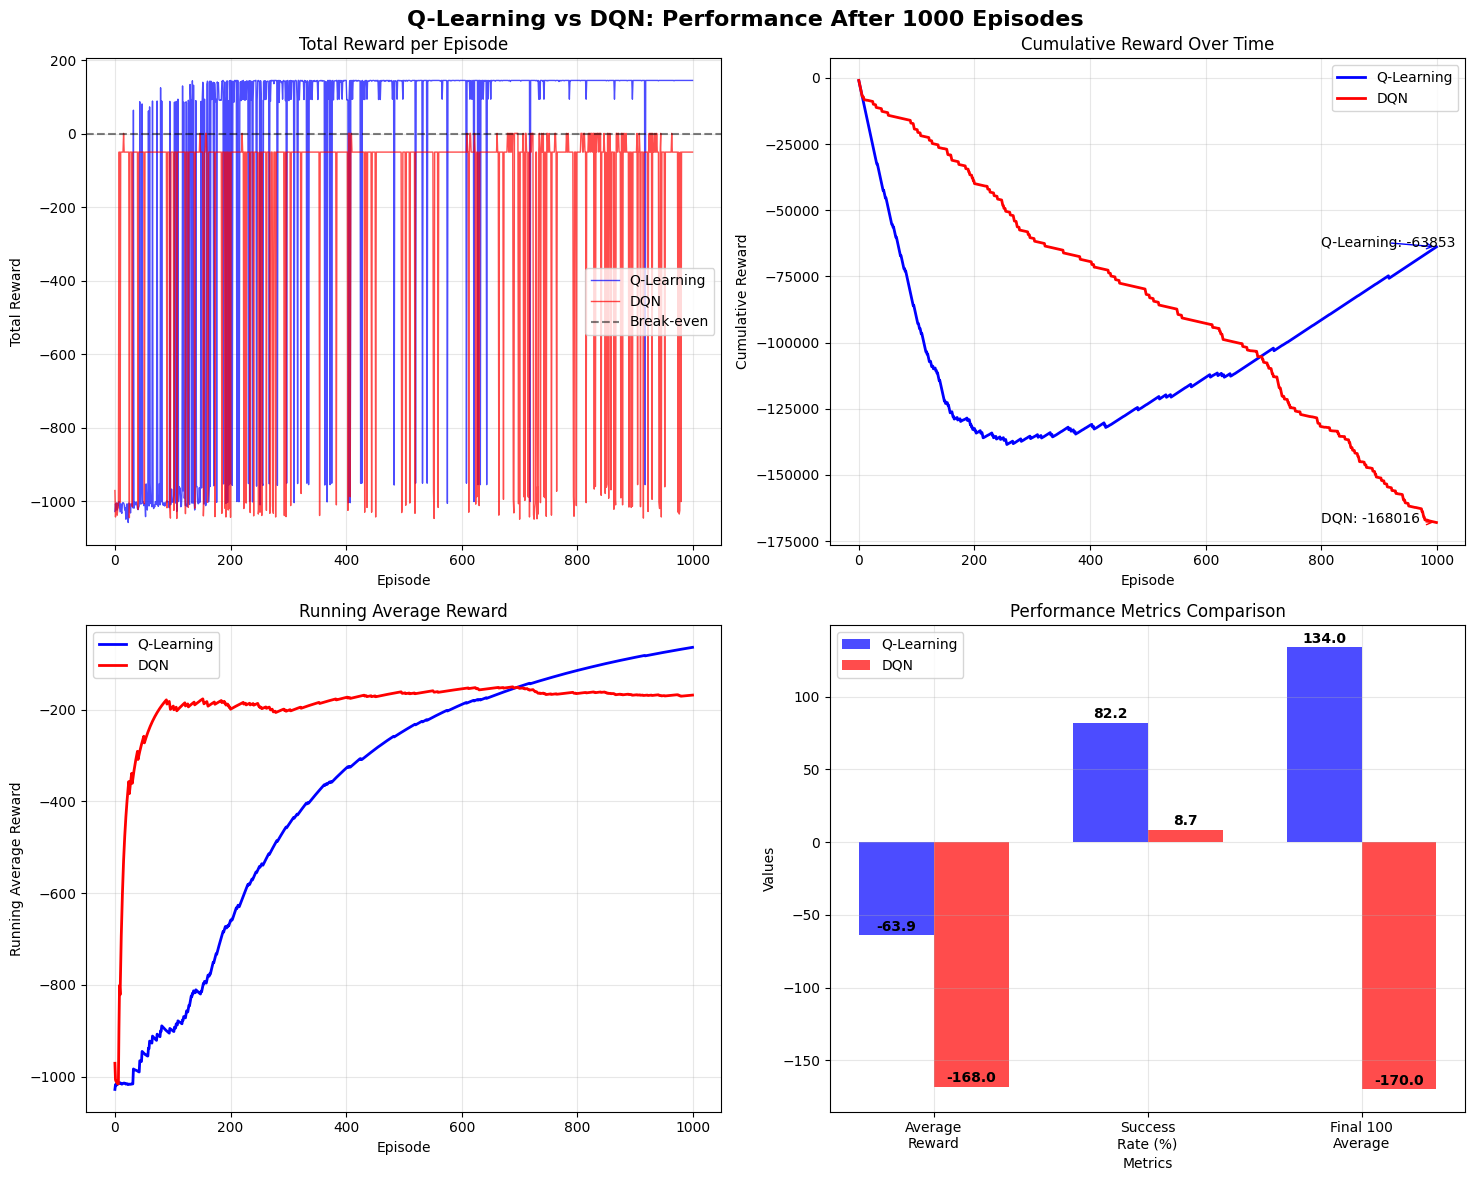


🔬 ANSWERS TO RESEARCH QUESTIONS
❓ HOW DOES AGENT PERFORMANCE IMPROVE OVER TIME?
--------------------------------------------------
📈 Q-Learning Performance Improvement:
   Early episodes (1-100): -899.04
   Late episodes (901-1000): 133.97
   Total improvement: +1033.01

📈 DQN Performance Improvement:
   Early episodes (1-100): -194.75
   Late episodes (901-1000): -169.97
   Total improvement: +24.78

❓ WHICH ALGORITHM PERFORMED BETTER AFTER 1000 EPISODES?
------------------------------------------------------------
🏆 WINNER: Q-Learning
📊 Performance Summary:
   Q-Learning average: -63.85
   DQN average: -168.02
   Performance margin: 104.16
   Statistical significance: Yes (p=0.0000)

🔍 KEY INSIGHTS:
• Q-Learning showed better learning progression over time
• Q-Learning achieved higher success rate

🏗️ ARCHITECTURE COMPARISON:
   Q-Learning: Tabular method with 1000 episodes
   DQN: Neural network (96→32→8) with experience replay
   Q-Learning advantages: Faster convergence, guarante

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

def run_fair_comparison():
    """
    Run fair comparison using your exact Q-learning and DQN implementations
    Both trained for 1000 episodes as requested in question 2
    """
    print("🔬 QUESTION 2: POLICY PERFORMANCE COMPARISON")
    print("🎯 Comparing Q-Learning vs DQN after 1000 episodes")
    print("=" * 60)

    # ----------------------------------------------------------------
    # 1. TRAIN Q-LEARNING AGENT (using your implementation)
    # ----------------------------------------------------------------
    print("🧠 Training Q-Learning Agent for 1000 episodes...")

    # Create Q-learning environment and agent
    env_q = GridEnvironment()
    agent_q = QLearningAgent(
        env=env_q,
        learning_rate=0.1,
        discount_factor=0.9,
        exploration_rate=1.0,
        exploration_decay=0.995,
        min_exploration=0.01
    )

    # Train for exactly 1000 episodes
    q_rewards = agent_q.train(episodes=1000, verbose=True)

    # ----------------------------------------------------------------
    # 2. TRAIN DQN AGENT (using your implementation)
    # ----------------------------------------------------------------
    print("\n🤖 Training DQN Agent for 1000 episodes...")

    # Create DQN environment and agent
    env_dqn = GridEnvironment2()
    agent_dqn = SimplifiedDQNAgent(
        env=env_dqn,
        learning_rate=0.01,
        gamma=0.95,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.98
    )

    # Train for exactly 1000 episodes
    dqn_rewards = agent_dqn.train(episodes=1000)

    return q_rewards, dqn_rewards, agent_q, agent_dqn

def analyze_performance(q_rewards, dqn_rewards):
    """
    Analyze and compare performance metrics
    """
    print("\n📊 PERFORMANCE ANALYSIS AFTER 1000 EPISODES")
    print("=" * 60)

    # Calculate metrics
    q_avg = np.mean(q_rewards)
    dqn_avg = np.mean(dqn_rewards)

    q_cumulative = np.cumsum(q_rewards)
    dqn_cumulative = np.cumsum(dqn_rewards)

    q_success_rate = sum(1 for r in q_rewards if r > 0) / len(q_rewards) * 100
    dqn_success_rate = sum(1 for r in dqn_rewards if r > 0) / len(dqn_rewards) * 100

    q_final_100 = np.mean(q_rewards[-100:])
    dqn_final_100 = np.mean(dqn_rewards[-100:])

    # Print comparison results
    print(f"🧠 Q-LEARNING RESULTS:")
    print(f"   📈 Average reward per episode: {q_avg:.2f}")
    print(f"   📊 Cumulative reward: {q_cumulative[-1]:.0f}")
    print(f"   ✅ Success rate: {q_success_rate:.1f}%")
    print(f"   🎯 Final 100 episodes avg: {q_final_100:.2f}")
    print(f"   🏆 Best episode: {max(q_rewards)}")
    print(f"   💥 Worst episode: {min(q_rewards)}")
    print(f"   📏 Standard deviation: {np.std(q_rewards):.2f}")

    print(f"\n🤖 DQN RESULTS:")
    print(f"   📈 Average reward per episode: {dqn_avg:.2f}")
    print(f"   📊 Cumulative reward: {dqn_cumulative[-1]:.0f}")
    print(f"   ✅ Success rate: {dqn_success_rate:.1f}%")
    print(f"   🎯 Final 100 episodes avg: {dqn_final_100:.2f}")
    print(f"   🏆 Best episode: {max(dqn_rewards)}")
    print(f"   💥 Worst episode: {min(dqn_rewards)}")
    print(f"   📏 Standard deviation: {np.std(dqn_rewards):.2f}")

    # Statistical significance test
    t_stat, p_value = stats.ttest_ind(q_rewards, dqn_rewards)

    print(f"\n📊 STATISTICAL COMPARISON:")
    print(f"   T-statistic: {t_stat:.4f}")
    print(f"   P-value: {p_value:.4f}")

    if p_value < 0.05:
        print(f"   ✅ Statistically significant difference (p < 0.05)")
    else:
        print(f"   ❌ No statistically significant difference (p ≥ 0.05)")

    # Determine winner
    print(f"\n🏆 DIRECT COMPARISON:")
    print(f"   Average Reward: Q-Learning ({q_avg:.2f}) vs DQN ({dqn_avg:.2f})")

    if q_avg > dqn_avg:
        winner = "Q-Learning"
        margin = q_avg - dqn_avg
        percentage = (margin / abs(dqn_avg)) * 100
    else:
        winner = "DQN"
        margin = dqn_avg - q_avg
        percentage = (margin / abs(q_avg)) * 100

    print(f"   🎯 Winner: {winner}")
    print(f"   📊 Margin: {margin:.2f} ({percentage:.1f}% better)")

    # Success rate comparison
    if q_success_rate > dqn_success_rate:
        success_winner = "Q-Learning"
        success_margin = q_success_rate - dqn_success_rate
    else:
        success_winner = "DQN"
        success_margin = dqn_success_rate - q_success_rate

    print(f"   ✅ Success Rate Winner: {success_winner} (+{success_margin:.1f}%)")

    return {
        'q_avg': q_avg,
        'dqn_avg': dqn_avg,
        'q_cumulative': q_cumulative,
        'dqn_cumulative': dqn_cumulative,
        'q_success_rate': q_success_rate,
        'dqn_success_rate': dqn_success_rate,
        'winner': winner,
        'margin': margin,
        'p_value': p_value
    }

def plot_comparison(q_rewards, dqn_rewards, title="Q-Learning vs DQN Comparison"):
    """
    Create comprehensive comparison plots
    """
    # Calculate statistics
    q_cumulative = np.cumsum(q_rewards)
    dqn_cumulative = np.cumsum(dqn_rewards)

    q_mean = q_cumulative / (np.arange(len(q_rewards)) + 1)
    dqn_mean = dqn_cumulative / (np.arange(len(dqn_rewards)) + 1)

    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Total rewards per episode
    axs[0, 0].plot(q_rewards, label='Q-Learning', color='blue', alpha=0.7, linewidth=1)
    axs[0, 0].plot(dqn_rewards, label='DQN', color='red', alpha=0.7, linewidth=1)
    axs[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Break-even')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Total Reward')
    axs[0, 0].set_title('Total Reward per Episode')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # Plot 2: Cumulative rewards
    axs[0, 1].plot(q_cumulative, label='Q-Learning', color='blue', linewidth=2)
    axs[0, 1].plot(dqn_cumulative, label='DQN', color='red', linewidth=2)
    axs[0, 1].set_xlabel('Episode')
    axs[0, 1].set_ylabel('Cumulative Reward')
    axs[0, 1].set_title('Cumulative Reward Over Time')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # Add annotations for final values
    axs[0, 1].annotate(f'Q-Learning: {q_cumulative[-1]:.0f}',
                      xy=(len(q_cumulative)-1, q_cumulative[-1]),
                      xytext=(len(q_cumulative)-200, q_cumulative[-1]),
                      arrowprops=dict(arrowstyle='->', color='blue'))
    axs[0, 1].annotate(f'DQN: {dqn_cumulative[-1]:.0f}',
                      xy=(len(dqn_cumulative)-1, dqn_cumulative[-1]),
                      xytext=(len(dqn_cumulative)-200, dqn_cumulative[-1]),
                      arrowprops=dict(arrowstyle='->', color='red'))

    # Plot 3: Running average
    axs[1, 0].plot(q_mean, label='Q-Learning', color='blue', linewidth=2)
    axs[1, 0].plot(dqn_mean, label='DQN', color='red', linewidth=2)
    axs[1, 0].set_xlabel('Episode')
    axs[1, 0].set_ylabel('Running Average Reward')
    axs[1, 0].set_title('Running Average Reward')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)

    # Plot 4: Performance metrics comparison
    metrics = ['Average\nReward', 'Success\nRate (%)', 'Final 100\nAverage']
    q_values = [np.mean(q_rewards),
                sum(1 for r in q_rewards if r > 0) / len(q_rewards) * 100,
                np.mean(q_rewards[-100:])]
    dqn_values = [np.mean(dqn_rewards),
                  sum(1 for r in dqn_rewards if r > 0) / len(dqn_rewards) * 100,
                  np.mean(dqn_rewards[-100:])]

    x = np.arange(len(metrics))
    width = 0.35

    axs[1, 1].bar(x - width/2, q_values, width, label='Q-Learning', color='blue', alpha=0.7)
    axs[1, 1].bar(x + width/2, dqn_values, width, label='DQN', color='red', alpha=0.7)
    axs[1, 1].set_xlabel('Metrics')
    axs[1, 1].set_ylabel('Values')
    axs[1, 1].set_title('Performance Metrics Comparison')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(metrics)
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)

    # Add value labels on bars
    for i, (q_val, dqn_val) in enumerate(zip(q_values, dqn_values)):
        axs[1, 1].text(i - width/2, q_val + 1, f'{q_val:.1f}',
                      ha='center', va='bottom', fontweight='bold')
        axs[1, 1].text(i + width/2, dqn_val + 1, f'{dqn_val:.1f}',
                      ha='center', va='bottom', fontweight='bold')

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def answer_research_questions(q_rewards, dqn_rewards, metrics):
    """
    Answer the specific research questions from Question 2
    """
    print("\n🔬 ANSWERS TO RESEARCH QUESTIONS")
    print("=" * 60)

    # Question 2a: How does agent performance improve over time?
    print("❓ HOW DOES AGENT PERFORMANCE IMPROVE OVER TIME?")
    print("-" * 50)

    # Analyze improvement for Q-Learning
    q_early = np.mean(q_rewards[:100])
    q_late = np.mean(q_rewards[-100:])
    q_improvement = q_late - q_early

    print(f"📈 Q-Learning Performance Improvement:")
    print(f"   Early episodes (1-100): {q_early:.2f}")
    print(f"   Late episodes (901-1000): {q_late:.2f}")
    print(f"   Total improvement: {q_improvement:+.2f}")

    # Analyze improvement for DQN
    dqn_early = np.mean(dqn_rewards[:100])
    dqn_late = np.mean(dqn_rewards[-100:])
    dqn_improvement = dqn_late - dqn_early

    print(f"\n📈 DQN Performance Improvement:")
    print(f"   Early episodes (1-100): {dqn_early:.2f}")
    print(f"   Late episodes (901-1000): {dqn_late:.2f}")
    print(f"   Total improvement: {dqn_improvement:+.2f}")

    # Question 2b: Which algorithm performed better?
    print(f"\n❓ WHICH ALGORITHM PERFORMED BETTER AFTER 1000 EPISODES?")
    print("-" * 60)

    print(f"🏆 WINNER: {metrics['winner']}")
    print(f"📊 Performance Summary:")
    print(f"   Q-Learning average: {metrics['q_avg']:.2f}")
    print(f"   DQN average: {metrics['dqn_avg']:.2f}")
    print(f"   Performance margin: {metrics['margin']:.2f}")
    print(f"   Statistical significance: {'Yes' if metrics['p_value'] < 0.05 else 'No'} (p={metrics['p_value']:.4f})")

    # Provide insights
    print(f"\n🔍 KEY INSIGHTS:")
    if q_improvement > dqn_improvement:
        print("• Q-Learning showed better learning progression over time")
    else:
        print("• DQN showed better learning progression over time")

    if metrics['q_success_rate'] > metrics['dqn_success_rate']:
        print("• Q-Learning achieved higher success rate")
    else:
        print("• DQN achieved higher success rate")

    # Architecture comparison
    print(f"\n🏗️ ARCHITECTURE COMPARISON:")
    print(f"   Q-Learning: Tabular method with {len(q_rewards)} episodes")
    print(f"   DQN: Neural network (96→32→8) with experience replay")
    print(f"   Q-Learning advantages: Faster convergence, guaranteed convergence")
    print(f"   DQN advantages: Function approximation, scalability")

def run_complete_comparison():
    """
    Run the complete comparison for Question 2
    """
    print("🚀 RUNNING COMPLETE COMPARISON FOR QUESTION 2")
    print("🎯 Policy Performance: Q-Learning vs DQN after 1000 episodes")
    print("=" * 70)

    # Run training
    q_rewards, dqn_rewards, q_agent, dqn_agent = run_fair_comparison()

    # Analyze performance
    metrics = analyze_performance(q_rewards, dqn_rewards)

    # Create visualizations
    plot_comparison(q_rewards, dqn_rewards, "Q-Learning vs DQN: Performance After 1000 Episodes")

    # Answer research questions
    answer_research_questions(q_rewards, dqn_rewards, metrics)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Episode': range(1, len(q_rewards) + 1),
        'Q_Learning_Reward': q_rewards,
        'DQN_Reward': dqn_rewards,
        'Q_Learning_Cumulative': np.cumsum(q_rewards),
        'DQN_Cumulative': np.cumsum(dqn_rewards),
        'Q_Learning_Success': [1 if r > 0 else 0 for r in q_rewards],
        'DQN_Success': [1 if r > 0 else 0 for r in dqn_rewards]
    })

    print(f"\n📊 Results DataFrame created with {len(results_df)} rows")
    print("Sample data:")
    print(results_df.head())

    # Save results
    results_df.to_csv('q_learning_vs_dqn_comparison.csv', index=False)
    print("📁 Results saved to 'q_learning_vs_dqn_comparison.csv'")

    return {
        'q_rewards': q_rewards,
        'dqn_rewards': dqn_rewards,
        'q_agent': q_agent,
        'dqn_agent': dqn_agent,
        'metrics': metrics,
        'results_df': results_df
    }

# ====================================================================
# EXECUTE THE COMPARISON
# ====================================================================

print("✅ Comparison functions ready!")

print("\nThis will:")
print("• Train both agents for exactly 1000 episodes")
print("• Compare average rewards per episode")
print("• Analyze performance improvement over time")
print("• Determine which algorithm performed better")
print("• Provide statistical significance testing")
print("• Create comprehensive visualizations")
print("• Save results to CSV file")

#  to run the comparison:
results = run_complete_comparison()